# MLP on MINST Dataset

In this notebook, we will be making a multi-layer Perceptron to classify the MNIST dataset. We will be using softmax as our criteria.

In [1]:
include("../src/NN.jl")
# Pkg.add("NN")
using NN
using PyPlot

[0.761594 0.964028; -0.761594 0.995055; 0.761594 -0.964028; -0.995055 -0.995055]


[0.839949 0.211952; 0.839949 0.0493302; 1.25992 0.423905; 0.0197321 0.0197321]


# Data Generation & Datasplit

We will be splitting the data into three sets: training, validation and testing sets. Corresponding percentage will be 80%, 10% and 10%.

In [2]:
include("../util/datasets.jl")
#data generation:
X,Y = mnistData(;ttl=5000)


(
[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0],

[9.0; 4.0; … ; 4.0; 3.0])

In [3]:
#data split:
train_set, test_set, validation_set = datasplit(X,Y)
trX, trY = train_set[1], train_set[2]
valX, valY = validation_set[1], validation_set[2]
teX, teY = test_set[1], test_set[2]
println("Size of train set:$(size(trX)), size of val set:$(size(valX)), size of test set:$(size(teX))")

Size of train set:(4000,784), size of val set:(500,784), size of test set:(500,784)


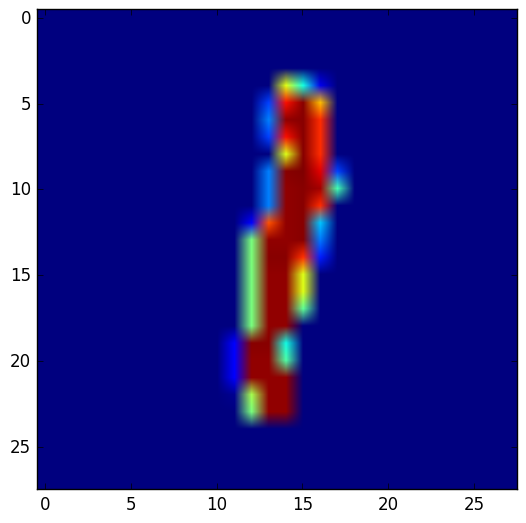

PyObject <matplotlib.image.AxesImage object at 0x3679de5d0>

In [4]:
i = convert(Int, ceil(rand() * size(trY)[1]))
x =reshape(trX[i,:], 28,28) ./ 256
imshow(x)

# Network Structure

## Approach using Sigmoid function

We will be using Sigmoid function as our non-linear layer in this approach:
`Sigmoid` function is simply defined as: 

$$\sigma(x) = \frac{1}{1 + e^{-x}} $$

The behavior of `sigmoid` function is that the value would be close to 0 or 1 when x is large either in the negative side or positive side.

Additionally, the derivative of `sigmoid` could be expressed in terms of itself, making it extremly simple:
   
$$\frac{\partial}{\partial x} \sigma(x) = \sigma(x)( 1 - \sigma(x))$$

In [5]:
function build_mlp_sigmoid()
    layers = [
        InputLayer((1,784)), # dummy batch size
        DropoutLayer(0.2),
        DenseLayer(800;init_type="Normal"),
        Sigmoid(),
        DropoutLayer(0.5),
        DenseLayer(800;init_type="Normal"),
        Sigmoid(),
        DropoutLayer(0.5),
        DenseLayer(10;init_type="Normal")
    ]
    criteria = SoftMaxCrossEntropyLoss()
    net = SequentialNet(layers, criteria)
    return net
end

  likely near /Users/Grendel/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/Grendel/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/Grendel/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/Grendel/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/Grendel/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/Grendel/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/Grendel/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/Grendel/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/Grendel/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/Grendel/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/Grendel/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/Grendel/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/Grendel/.julia/v0.5/IJulia/src/kernel.jl:31
in show at /Users/Grendel/.julia/v0.5/PyCall/src/PyCall.jl
  likely near /Users/Grendel/.julia/v0.5/IJulia/src/kernel.jl:31
in show at /Users/Grendel/.juli

build_mlp_sigmoid (generic function with 1 method)

In [6]:
function get_corr(pred, answ)
    return length(filter(e -> abs(e) < 1e-5, pred-answ))
end

function train(net::SequentialNet, train_set, validation_set; batch_size::Int64 = 64, ttl_epo::Int64 = 10, lrSchedule = (x -> 0.01), alpha::Float64 = 0.9, verbose=0)
    X, Y = train_set
    valX, valY = validation_set
    local N = size(Y)[1]
    local batch=0
    local epo_losses = []
    local epo_accus = []
    
    local val_losses = []
    local val_accu   = []
    for epo = 1:ttl_epo
        local num_batch = ceil(N/batch_size)
        if verbose > 0
            println("Epo $(epo) num batches : $(num_batch)")
        end
        all_losses = []
        epo_cor = 0
        for bid = 0:(num_batch-1)
            batch += 1
            local sidx::Int = convert(Int64, bid*batch_size+1)
            local eidx::Int = convert(Int64, min(N, (bid+1)*batch_size))
            local batch_X = X[sidx:eidx,:]
            local batch_Y = Y[sidx:eidx,:]
            loss, _ = forward(net, batch_X, batch_Y)
            backward(net, batch_Y)
            append!(all_losses, mean(loss))
            for i = 1:length(net.layers)
                local layer = net.layers[i]
                local gradi = lrSchedule(epo) * getGradient(layer) / batch_size
                local veloc = getVelocity(layer) * alpha - gradi
                local theta = getParam(layer) + alpha * veloc - gradi
                if verbose > 2
                    print("Layer $(i)")
                    print("\tGradient: $(sum(abs(theta - getLDiff(layer))))")
                    if verbose > 1
                        print("\tLastloss: $(sum(abs(layer.last_loss)))")
                    end
                    println()
                end
                setParam!(layer, theta)
            end

            _, pred = forward(net, batch_X, batch_Y; deterministics = true)
            epo_cor  += length(filter(e ->  abs(e) < 1e-5, pred - batch_Y))
            local acc = length(filter(e -> abs(e) < 1e-5, pred - batch_Y)) / batch_size

            if verbose > 1
                println("[$(bid)/$(num_batch)]Loss is: $(loss)\tAccuracy:$(acc)")
            end
        end
        local epo_loss = mean(all_losses)
        local epo_accu = epo_cor / N
        append!(epo_losses, epo_loss)
        append!(epo_accus, epo_accu)
        
        # Run validation set
        v_ls, v_pd = forward(net, valX, valY)
        local v_loss = mean(v_ls)
        v_size = size(valX)[1]
        v_accu = get_corr(v_pd, valY) / v_size
        append!(val_losses, v_loss)
        append!(val_accu,   v_accu)
        
        if verbose > 0
            println("Epo $(epo) has loss :$(epo_loss)\t\taccuracy : $(epo_accu)")
        end
    end
    return epo_losses,epo_accus, val_losses, val_accu
end

train (generic function with 1 method)

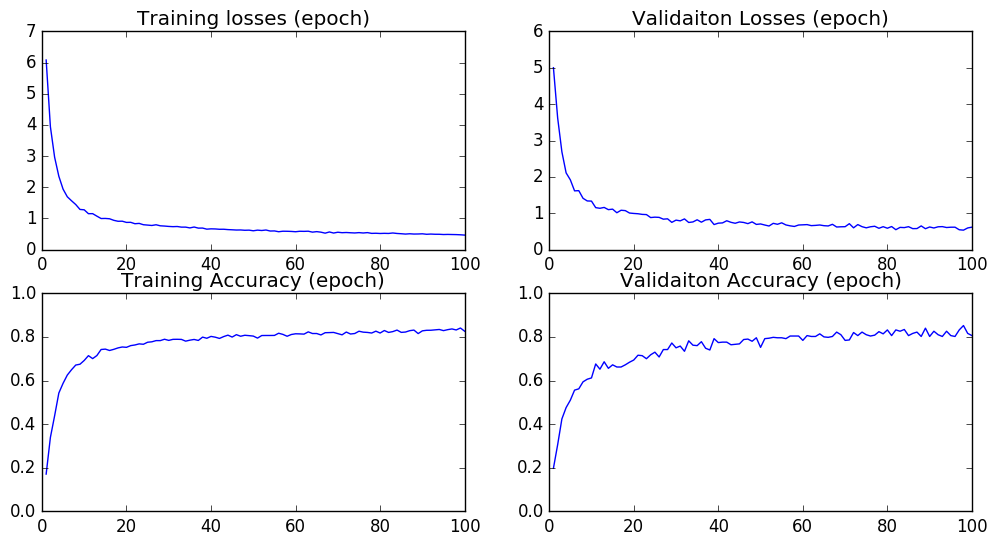

In [7]:
sigmoid_net = build_mlp_sigmoid()
epo_losses, epo_accu, val_losses, val_accu = train(sigmoid_net, (trX, trY), (valX, valY); 
                ttl_epo = 100, batch_size = 100, lrSchedule = x -> 0.01, verbose=0, alpha=0.9)
figure(figsize=(12,6))
subplot(221)
plot(1:length(epo_losses), epo_losses)
title("Training losses (epoch)")

subplot(223)
plot(1:length(epo_accu), epo_accu)
ylim([0, 1])
title("Training Accuracy (epoch)")

subplot(222)
plot(1:length(val_losses), val_losses)
title("Validaiton Losses (epoch)")

subplot(224)
plot(1:length(val_accu), val_accu)
ylim([0, 1])
title("Validaiton Accuracy (epoch)")

show()


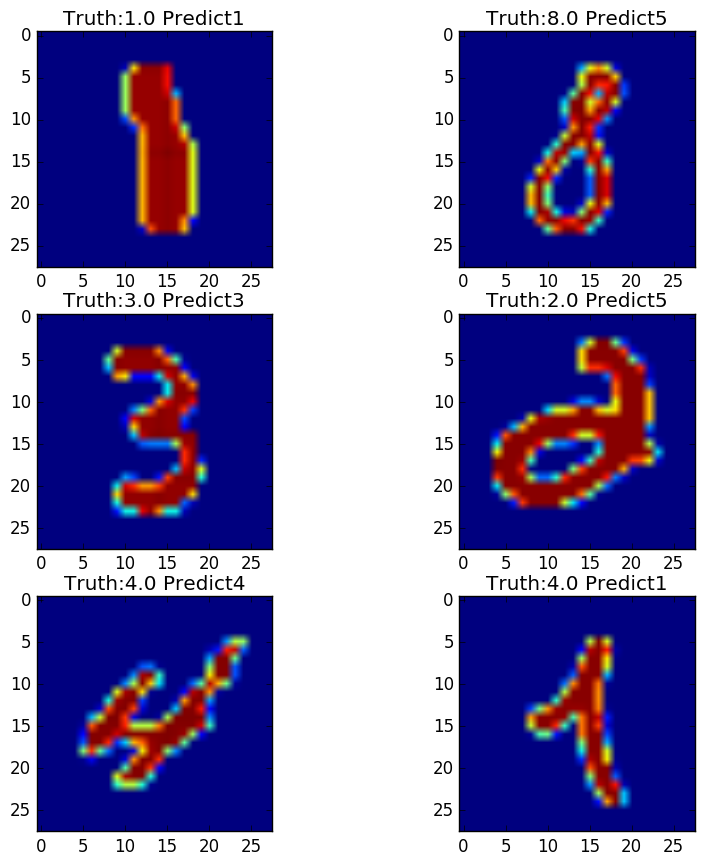

Testing Accuracy:0.826


In [8]:
train_loss, pred = forward(sigmoid_net, teX, teY; deterministics = true)
N = size(teX)[1]
corr = length(filter(i-> abs(pred[i] - teY[i]) <  1e-5, 1:N))
right_idx = filter(i-> abs(pred[i] - teY[i]) <  1e-5, 1:N)[1:3]
wrong_idx = filter(i-> abs(pred[i] - teY[i]) >= 1e-5, 1:N)[1:3]

println("Testing Accuracy:$(corr/N)")

figure(figsize=(10,10))
subplot(321)
imshow(reshape(teX[right_idx[1],:], 28,28))
title("Truth:$(teY[right_idx[1]]) Predict$(pred[right_idx[1]])")

subplot(322)
imshow(reshape(teX[wrong_idx[1],:], 28,28))
title("Truth:$(teY[wrong_idx[1]]) Predict$(pred[wrong_idx[1]])")

subplot(323)
imshow(reshape(teX[right_idx[2],:], 28,28))
title("Truth:$(teY[right_idx[2]]) Predict$(pred[right_idx[2]])")

subplot(324)
imshow(reshape(teX[wrong_idx[2],:], 28,28))
title("Truth:$(teY[wrong_idx[2]]) Predict$(pred[wrong_idx[2]])")

subplot(325)
imshow(reshape(teX[right_idx[3],:], 28,28))
title("Truth:$(teY[right_idx[3]]) Predict$(pred[right_idx[3]])")

subplot(326)
imshow(reshape(teX[wrong_idx[3],:], 28,28))
title("Truth:$(teY[wrong_idx[3]]) Predict$(pred[wrong_idx[3]])")
show()

## Another approach using ReLU

In the other approach, we will be using ReLU as our non-linear layer.

In [14]:
function build_mlp_relu()
    layers = [
        InputLayer((1, 784)), # Dummy batch size
        DropoutLayer(0.2),
        DenseLayer(800;init_type="Uniform"),
        ReLu(),
        DropoutLayer(0.5),
        DenseLayer(800;init_type="Uniform"),
        ReLu(),
        DropoutLayer(0.5),
        DenseLayer(10;init_type="Normal")
    ]
    criteria = SoftMaxCrossEntropyLoss()
    net = SequentialNet(layers, criteria)
    return net
end

build_mlp_relu (generic function with 1 method)

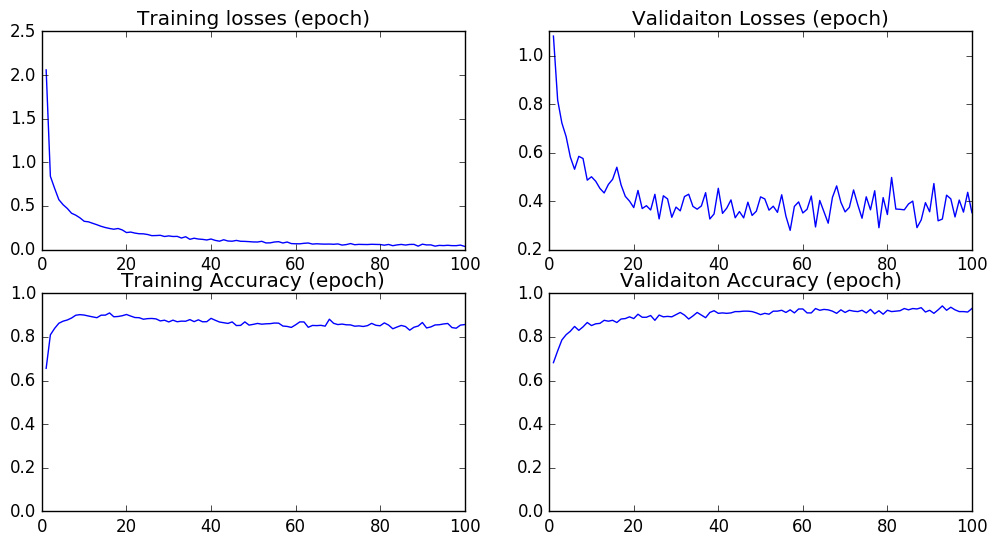

In [15]:
relu_net = build_mlp_relu()
epo_losses, epo_accu, val_losses, val_accu = train(relu_net, (trX, trY), (valX, valY); 
                ttl_epo = 100, batch_size = 100, lrSchedule = x -> 0.01, verbose=0, alpha=0.9)

figure(figsize=(12,6))
subplot(221)
plot(1:length(epo_losses), epo_losses)
title("Training losses (epoch)")

subplot(223)
plot(1:length(epo_accu), epo_accu)
ylim([0, 1])
title("Training Accuracy (epoch)")

subplot(222)
plot(1:length(val_losses), val_losses)
title("Validaiton Losses (epoch)")

subplot(224)
plot(1:length(val_accu), val_accu)
ylim([0, 1])
title("Validaiton Accuracy (epoch)")

show()

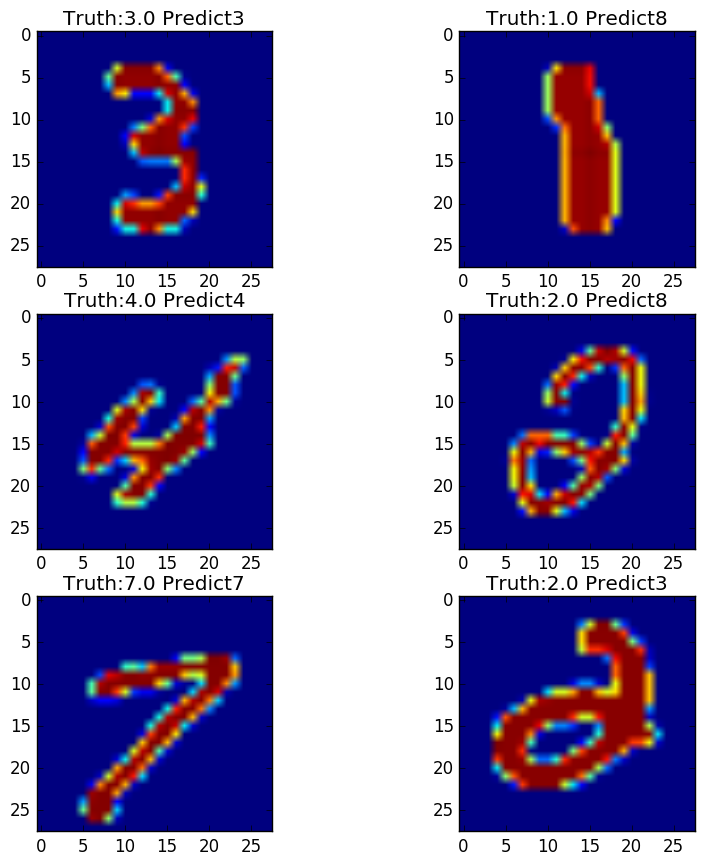

Testing Accuracy:0.766


In [16]:
train_loss, pred = forward(relu_net, teX, teY; deterministics = true)
N = size(teX)[1]
corr = length(filter(i-> abs(pred[i] - teY[i]) <  1e-5, 1:N))
right_idx = filter(i-> abs(pred[i] - teY[i]) <  1e-5, 1:N)[1:3]
wrong_idx = filter(i-> abs(pred[i] - teY[i]) >= 1e-5, 1:N)[1:3]

println("Testing Accuracy:$(corr/N)")

figure(figsize=(10,10))
subplot(321)
imshow(reshape(teX[right_idx[1],:], 28,28))
title("Truth:$(teY[right_idx[1]]) Predict$(pred[right_idx[1]])")

subplot(322)
imshow(reshape(teX[wrong_idx[1],:], 28,28))
title("Truth:$(teY[wrong_idx[1]]) Predict$(pred[wrong_idx[1]])")

subplot(323)
imshow(reshape(teX[right_idx[2],:], 28,28))
title("Truth:$(teY[right_idx[2]]) Predict$(pred[right_idx[2]])")

subplot(324)
imshow(reshape(teX[wrong_idx[2],:], 28,28))
title("Truth:$(teY[wrong_idx[2]]) Predict$(pred[wrong_idx[2]])")

subplot(325)
imshow(reshape(teX[right_idx[3],:], 28,28))
title("Truth:$(teY[right_idx[3]]) Predict$(pred[right_idx[3]])")

subplot(326)
imshow(reshape(teX[wrong_idx[3],:], 28,28))
title("Truth:$(teY[wrong_idx[3]]) Predict$(pred[wrong_idx[3]])")
show()

# Result Analysis